In [1]:
from numpy.fft import fftn, fftfreq
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
import sys

import astropy.cosmology
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u

arcmin = 2.908882086656e-4 # [rad] ... PI / 180 / 60 //
arcsec = 4.848136811094e-6 # [rad] ... arcmin / 60 //
GHz = 1e9

def arcsec_to_cMpc(l_arcsec, z):
    l_rad = l_arcsec * u.arcsec / u.radian
    l_cMpc = ( cosmo.comoving_transverse_distance(z) * l_rad ).to(u.Mpc)
    return l_cMpc.value 

def freq_to_comdis(nu_obs, nu_rest):
    z = nu_rest / nu_obs - 1
    if z < 0:
        print("Error: z < 0")
        sys.exit(1)
    return cosmo.comoving_distance(z).to(u.Mpc).value

from line_model import line_dict 
line_names = list(line_dict.keys())
NLINE = len(line_names)
print(line_names)

['CO(1-0)', 'CO(2-1)', 'CO(3-2)', 'CO(4-3)', 'CO(5-4)', 'CO(6-5)', 'CO(7-6)', 'CO(8-7)', 'CO(9-8)', 'CO(10-9)', 'CO(11-10)', 'CO(12-11)', 'CO(13-12)', '[CII]158', '[OIII]88', '[NII]205', '[NII]122', '[CI](1-0)', '[CI](2-1)', '[OIII]5007', 'Halpha']


In [2]:
def load_data(path, zlim=[0,-1]):
    with h5py.File(path, "r") as f:
        attrs = dict(f.attrs)
        frequency = f["/frequency"][:] / GHz # [GHz]
        intensity = f["/total_intensity"][:]

        frequency = frequency[zlim[0]:zlim[1]]
        intensity = intensity[:, :, zlim[0]:zlim[1]]

        intensity_line = {}
        for line_name in line_names:
            dataset_name = "intensity_{}".format(line_name)
            if dataset_name in f:
                intensity_line[line_name] = f[dataset_name][:]
                intensity_line[line_name] = intensity_line[line_name][:, :, zlim[0]:zlim[1]]
                if "nden" in path:
                    print("Total number {}: ".format(line_name), np.sum(intensity_line))
    
    print("freqency shape: ", frequency.shape)
    print("intensity shape: ", intensity.shape)

    return frequency, intensity, intensity_line, attrs

def plot_mean(frequency, intensity, intensity_line, title=None, lines_to_show=line_names, ylim=None, nsmooth=1, logx=False):
    """
    plot mean intensity
    input: 
        frequency: (Nf+1,) frequency [GHz]
        intensity: (Nx, Ny, Nf) intensity [Jy/sr]
        intensity_line: (Nline, Nx, Ny, Nf) intensity [Jy/sr]
        title: title of the plot
        lines_to_show: list of line names to show
        ylim: y-axis limit
        nsmooth: smoothing scale
        logx: if True, use log scale for x-axis
    """

    plt.figure()
    plt.xlabel("Frequency [GHz]")
    plt.ylabel("Mean intensity [Jy/sr]")

    frequency_bin = 0.5 * (frequency[1:] + frequency[:-1])
    mean = np.mean(intensity, axis=(0, 1))
    if nsmooth > 1:
        mean = gaussian_filter(mean, sigma=nsmooth)
    plt.plot(frequency_bin, mean, color="k", label="total")

    count = 0
    for i, line_name in enumerate(line_names):
        if line_name in lines_to_show:
            mean_line = np.mean(intensity_line[line_name], axis=(0, 1))
            if nsmooth > 1:
                mean_line = gaussian_filter(mean_line, sigma=nsmooth)

            ls = "-" if count < 10 else "--"
            plt.plot(frequency_bin, mean_line, ls=ls, label=f"{line_name}")
            count += 1

    if len(lines_to_show) > 4:
        plt.legend(bbox_to_anchor=(1,1.1))
    else:
        plt.legend()
    plt.title(title)
    plt.ylim(ylim)
    plt.yscale("log")
    if logx:
        plt.xscale("log")
    
def show_map(frequency, intensity, intensity_line, side_length, lines_to_show=line_names, dy=1, use_log=False, smoothing=0):
    """
    show intensity map in x-z plane
    input:
        frequency: (Nf+1,) frequency [GHz]
        intensity: (Nx, Ny, Nf) intensity [Jy/sr]
        intensity_line: (Nline, Nx, Ny, Nf) intensity [Jy/sr]
        side_length: side length [arcsec]
        lines_to_show: list of line names to show
        use_log: if True, use log scale for intensity
        smoothing: smoothing scale
    """

    Nmap = len(lines_to_show) + 1

    plt.figure(figsize=(10, Nmap*2))
    plt.subplots_adjust(hspace=1)

    fmin = frequency[0]
    fmax = frequency[-1]

    def show_ticks(fmin=fmin, fmax=fmax, freq=frequency):
        if fmax - fmin < 150:
            tick_values = [ int(fmin/100) * 100 + 20*i for i in range(10) ]
        elif fmax - fmin > 10000:
            tick_values = [ int(fmin/10000) * 10000 + 2000*i for i in range(30) ]
        else:
            tick_values = [ int(fmin/100) * 100 + 100*i for i in range(10) ]
        tick_values = [v for v in tick_values if v > fmin and v < fmax]
        interpolator = interp1d(freq, np.arange(len(freq)))
        tick_positions = interpolator(tick_values)
        plt.xticks(ticks=tick_positions, labels=tick_values)

    def show_a_map(imap, map, side_length=side_length, iy=0, dy=1, vmin=None, vmax=None, label=None, use_log=use_log):
        plt.subplot2grid((Nmap,1), (imap,0))
        map_xz = map[:, iy:iy+dy, :].sum(axis=1)
        if use_log: map_xz = np.log10(map_xz)
        if smoothing > 0:
            map_xz = gaussian_filter(map_xz, sigma=smoothing)
        cmap = plt.cm.viridis
        cmap.set_bad(color=cmap(0))
        plt.imshow(map_xz, origin="lower", aspect="auto", cmap=cmap, vmin=vmin, vmax=vmax)
        plt.title(label)
        plt.colorbar(label="log I [Jy/sr]")
        plt.yticks([])
        x = side_length / 3600
        plt.ylabel("{:.1f} deg".format(x))
        plt.xlabel("frequency [GHz]")
        show_ticks()

    if dy < 0:
        dy = intensity.shape[1]
    print(f"Projection along y-axis: {dy:d} slices")
        
    show_a_map(0, intensity, dy=dy, label="total")
    count = 0
    for i, line_name in enumerate(line_names):
        if line_name in lines_to_show:
            show_a_map(count+1, intensity_line[line_name], dy=dy, label=line_name)
            count += 1

def my_fft(X, L=None, b=1.): # b = 2 * np.pi for inverse FT
    """
    Actually whatever dimension is ok
    input:
        X: (Nx, Ny, Nz) data 
        L: (3,) or float, box size
        b: normalization factor
    output:
        ft: (Nx, Ny, Nz) Fourier transform
        freq: (Nx, Ny, Nz) frequency
    """

    dim = len(X.shape)
    N = np.array(X.shape)

    if L is None:
        L = N
    elif np.isscalar(L):
        L = L * np.ones(dim)

    dx = np.array([float(l)/float(n) for l, n in zip(L, N)])
    Vx = np.prod(dx) # volume of a cell

    freq = [fftfreq(n, d=d)*2*np.pi for n, d in zip(N, dx)]
    ft = Vx * fftn(X) * np.sqrt(1/np.abs(b)) ** dim
    
    return ft, freq

def calc_noise_power(sigma_noise_Jy_sr, freq, intensity, side_length=3600, line_name="CO(1-0)", with_hlittle=True):
       
    redshifts = line_dict[line_name][0] / GHz / freq - 1
    redshift_mean = np.mean(redshifts)
    nu_rest = line_dict[line_name][0] / GHz

    Lx = arcsec_to_cMpc(side_length, redshift_mean) # [cMpc/h]
    Ly = arcsec_to_cMpc(side_length, redshift_mean) # [cMpc/h]
    Lz = freq_to_comdis(freq[0], nu_rest) - freq_to_comdis(freq[-1], nu_rest) 

    dx = Lx / intensity.shape[0]
    dy = Ly / intensity.shape[1]
    dz = Lz / intensity.shape[2]
    
    dL = np.array([dx, dy, dz])

    hlittle = cosmo.H0.value / 100
    if with_hlittle:
        dL *= hlittle
    dV = np.prod(dL) 

    P_noise = sigma_noise_Jy_sr**2 * dV

    return P_noise


def calc_power(freq_obs, intensity, side_length=3600, line_name="CO(1-0)", dlogk=0.2, with_hlittle=True, logkpara_min=-10, logkperp_min=-10, sigma_noise=0): 
    """
    input:
        freq: (N,) frequency [GHz]
        intensity: (Nx, Ny, Nf) intensity [arbitrary unit]
        side_length: side length [arcsec]
        line_name: line name for which the distance is calculated
        dlogk: bin width for logk
        with_hlittle: if True, multiply h
        logkpara_min: minimum value of logkpara
        logkperp_min: minimum value of logkperp
    output:
        k: (Nk,) wavenumber [h/cMpc^-1]
        power1d: (Nk,) power spectrum [input unit^2 * (cMpc/h)^3]
    """
    
    redshifts = line_dict[line_name][0] / GHz / freq_obs - 1
    redshift_mean = np.mean(redshifts)
    nu_rest = line_dict[line_name][0] / GHz

    print(f"Use {line_name} rest-frame frequency: {nu_rest:.2f} GHz")
    print(f"Frequency range: {freq_obs[0]:.2f} - {freq_obs[-1]:.2f} GHz")
    print(f"redshift: {redshifts[-1]:.2f} - {redshifts[0]:.2f} (mean: {redshift_mean:.2f})")
    
    Lx = arcsec_to_cMpc(side_length, redshift_mean) # [cMpc]
    Ly = arcsec_to_cMpc(side_length, redshift_mean) # [cMpc]
    Lz = freq_to_comdis(freq_obs[0], nu_rest) - freq_to_comdis(freq_obs[-1], nu_rest) # [cMpc]

    ## Fourier transform
    L = np.array([Lx, Ly, Lz])
    dL = np.array([Lx / intensity.shape[0], Ly / intensity.shape[1], Lz / intensity.shape[2]])
    hlittle = cosmo.H0.value / 100
    if with_hlittle:
        L *= hlittle # [cMpc/h]
        dL *= hlittle # [cMpc/h]
    V = np.prod(L) 
    dV = np.prod(dL) # [cMpc/h]^3
    
    ft, freq = my_fft(intensity, L=L)
    power_spectrum = np.abs(ft)**2 / V
    kx, ky, kz = np.meshgrid(freq[0], freq[1], freq[2], indexing='ij')

    ## noise power spectrum
    power_noise = sigma_noise**2 * dV

    ## compute angular-averaged power spectrum
    logk = np.log10(np.sqrt(kx**2 + ky**2 + kz**2))
    logkpara = np.log10(np.abs(kz))
    logkperp = np.log10(np.sqrt(kx**2 + ky**2))
    
    logk_bins = np.arange(-1.4, 1.3, dlogk)#dk=k*dlogk
    
    power1d = np.zeros(len(logk_bins) - 1)
    power1d_err = np.zeros(len(logk_bins) - 1)
    for i in range(len(logk_bins) - 1):
        mask = (logk >= logk_bins[i]) & (logk < logk_bins[i+1]) & (logkpara > logkpara_min) & (logkperp > logkperp_min)
        Nk = mask.sum()

        if np.any(mask):
            power1d[i] = np.mean(power_spectrum[mask])
            power1d_err[i] = (power1d[i] + power_noise) / np.sqrt(Nk)

    return 10**(0.5*(logk_bins[1:]+logk_bins[:-1])), power1d, power1d_err

### Power spectrum

freqency shape:  (50,)
intensity shape:  (1285, 1285, 49)
Use Halpha rest-frame frequency: 486000.00 GHz
Frequency range: 241625.95 - 393451.22 GHz
redshift: 0.24 - 1.01 (mean: 0.59)


/var/folders/k3/xbn82nk53n3d2b3ll0rk74vm0000gn/T/ipykernel_1633/3098966935.py:230: RuntimeWarning: divide by zero encountered in log10
  logk = np.log10(np.sqrt(kx**2 + ky**2 + kz**2))
/var/folders/k3/xbn82nk53n3d2b3ll0rk74vm0000gn/T/ipykernel_1633/3098966935.py:231: RuntimeWarning: divide by zero encountered in log10
  logkpara = np.log10(np.abs(kz))
/var/folders/k3/xbn82nk53n3d2b3ll0rk74vm0000gn/T/ipykernel_1633/3098966935.py:232: RuntimeWarning: divide by zero encountered in log10
  logkperp = np.log10(np.sqrt(kx**2 + ky**2))


Use Halpha rest-frame frequency: 486000.00 GHz
Frequency range: 241625.95 - 393451.22 GHz
redshift: 0.24 - 1.01 (mean: 0.59)
Use Halpha rest-frame frequency: 486000.00 GHz
Frequency range: 241625.95 - 393451.22 GHz
redshift: 0.24 - 1.01 (mean: 0.59)
[      0.               0.         2396847.12241656 1161564.81786155
  643900.56419172  447626.5974293   337889.25940138  263597.52537641
  238251.52845458  218035.95188517  205264.82041392  193856.47494457
  183398.80233463]
Use [OIII]5007 rest-frame frequency: 599700.00 GHz
Frequency range: 241625.95 - 393451.22 GHz
redshift: 0.52 - 1.48 (mean: 0.97)
Use [OIII]5007 rest-frame frequency: 599700.00 GHz
Frequency range: 241625.95 - 393451.22 GHz
redshift: 0.52 - 1.48 (mean: 0.97)


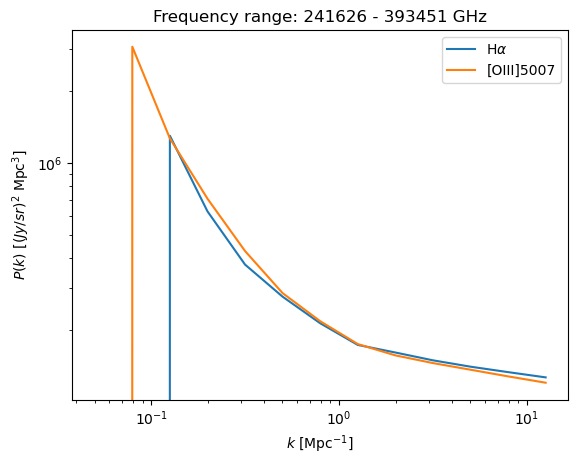

In [7]:
with_hlittle = False

path = "../output_TNG300-1/map_5400.0sec_fmin60000.0_fmax400000.0_angular4.2_spectral100.0_sigma0.2_alpha15.0_th-1.0.h5"
freq, intensity, intensity_line, attrs = load_data(path, zlim=[140,-1])

side_length = attrs["side_length"] # [arcsec]
dtheta = attrs["angular_resolution"] # [arcsec]
sigma_noise = 1e-3 / (dtheta * arcsec)**2 # [Jy/sr]

## compute power spectrum 
target_line = "Halpha" ## conversions from [arcsec->cMpc] and [Hz->cMpc] are done for this line
k, power, power_err = calc_power(freq, intensity, side_length=side_length, line_name=target_line, with_hlittle=with_hlittle, sigma_noise=sigma_noise)
for i, line_name in enumerate(line_names):
    if line_name == target_line:
        k, power_line, power_line_err = calc_power(freq, intensity_line[line_name], side_length=side_length, line_name=line_name, with_hlittle=with_hlittle)
 
## mock observation with noise intensity
intensity_noise = np.random.normal(0, sigma_noise, intensity.shape)
intensity_w_noise = intensity + intensity_noise
k, power_w_noise, power_err_w_noise = calc_power(freq, intensity_w_noise, side_length=side_length, line_name=target_line, with_hlittle=with_hlittle)
power_noise_pred = calc_noise_power(sigma_noise, freq, intensity, side_length=side_length, line_name=target_line, with_hlittle=with_hlittle)

print(power)
## plot power spectrum
plt.xscale("log")
plt.yscale("log")
plt.title(f"Frequency range: {freq[0]:.0f} - {freq[-1]:.0f} GHz")

#plt.errorbar(k, power_line, power_line_err,fmt='o',ecolor='black',markeredgecolor = "black",color='w')
plt.plot(k, power_line, label=r"H$\alpha$")
#plt.errorbar(k, power,power_err,fmt='o',ecolor='orange',markeredgecolor = "black",color='w')
#plt.plot(k, power,  label="total power")

#plt.plot(k, power_w_noise, label="observed (w/ noise)")
#plt.plot(k, power_w_noise - power_noise_pred, label="observed (obs - predicted noise)")

target_line = "[OIII]5007" ## conversions from [arcsec->cMpc] and [Hz->cMpc] are done for this line
k, power, power_err = calc_power(freq, intensity, side_length=side_length, line_name=target_line, with_hlittle=with_hlittle, sigma_noise=sigma_noise)
for i, line_name in enumerate(line_names):
    if line_name == target_line:
        k, power_line, power_line_err = calc_power(freq, intensity_line[line_name], side_length=side_length, line_name=line_name, with_hlittle=with_hlittle)
 
plt.plot(k, power_line, label="[OIII]5007")
#plt.errorbar(k, power,power_err,fmt='o',ecolor='orange',markeredgecolor = "black",color='w')

if with_hlittle:
    plt.xlabel(r"$k \ [h\ \rm Mpc^{-1}]$")
    plt.ylabel(r"$P(k)\ [(Jy/sr)^2\ (cMpc/h)^3]$")
else:
    plt.xlabel(r"$k \ [\rm Mpc^{-1}]$") 
    plt.ylabel(r"$P(k)\ [(Jy/sr)^2\ \rm Mpc^3]$")

plt.legend()
#plt.savefig("3d_power_spectrum_b2_factor10_without_noise.png", bbox_inches="tight", pad_inches=0.0)

In [5]:
freq

array([ 60000.   ,  60600.   ,  61206.   ,  61818.06 ,  62436.242,
        63060.6  ,  63691.21 ,  64328.12 ,  64971.402,  65621.12 ,
        66277.33 ,  66940.1  ,  67609.5  ,  68285.59 ,  68968.45 ,
        69658.14 ,  70354.72 ,  71058.266,  71768.84 ,  72486.54 ,
        73211.4  ,  73943.516,  74682.95 ,  75429.78 ,  76184.08 ,
        76945.914,  77715.375,  78492.53 ,  79277.45 ,  80070.234,
        80870.94 ,  81679.64 ,  82496.44 ,  83321.41 ,  84154.62 ,
        84996.164,  85846.125,  86704.586,  87571.63 ,  88447.35 ,
        89331.82 ,  90225.14 ,  91127.4  ,  92038.664,  92959.055,
        93888.65 ,  94827.53 ,  95775.805,  96733.57 ,  97700.9  ,
        98677.91 ,  99664.69 , 100661.336, 101667.95 , 102684.63 ,
       103711.48 , 104748.59 , 105796.08 , 106854.04 , 107922.58 ,
       109001.8  , 110091.82 , 111192.734, 112304.664, 113427.71 ,
       114561.984, 115707.61 , 116864.69 , 118033.336, 119213.664,
       120405.805, 121609.86 , 122825.95 , 124054.22 , 125294.

### Mean intensity

freqency shape:  (96,)
intensity shape:  (200, 200, 95)


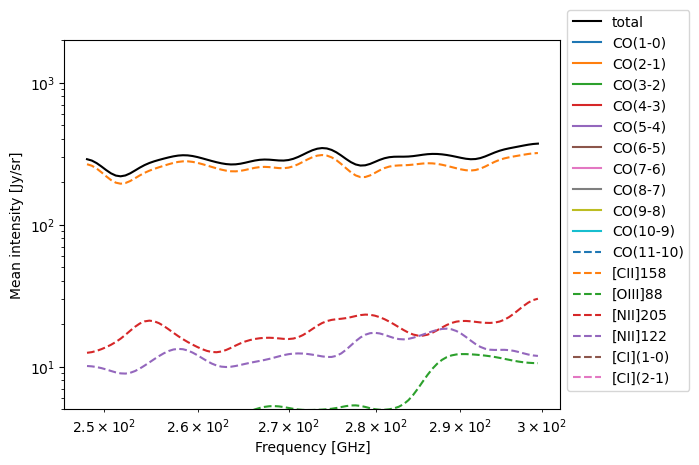

In [7]:
path = "../output_TNG300-1/map_5400.0sec_fmin248.0_fmax301.0_angular27.0_spectral500.0_sigma0.2_alpha15.0_th-1.0.h5"

freq, intensity, intensity_line, attrs = load_data(path)
plot_mean(freq, intensity, intensity_line, lines_to_show=["CO(1-0)", "CO(2-1)", "CO(3-2)", "CO(4-3)", "CO(5-4)", "CO(6-5)", "CO(7-6)", "CO(8-7)", "CO(9-8)", "CO(10-9)", "CO(11-10)", "[CII]158", "[OIII]88", "[NII]205", "[NII]122", "[CI](1-0)", "[CI](2-1)"], ylim=[5, 2e3], nsmooth=3, logx=True)

### Show map

freqency shape:  (96,)
intensity shape:  (200, 200, 95)
Projection along y-axis: 200 slices


/var/folders/k3/xbn82nk53n3d2b3ll0rk74vm0000gn/T/ipykernel_1217/3137085515.py:105: RuntimeWarning: divide by zero encountered in log10
  if use_log: map_xz = np.log10(map_xz)
/var/folders/k3/xbn82nk53n3d2b3ll0rk74vm0000gn/T/ipykernel_1217/3137085515.py:105: RuntimeWarning: divide by zero encountered in log10
  if use_log: map_xz = np.log10(map_xz)
/var/folders/k3/xbn82nk53n3d2b3ll0rk74vm0000gn/T/ipykernel_1217/3137085515.py:105: RuntimeWarning: divide by zero encountered in log10
  if use_log: map_xz = np.log10(map_xz)


freqency shape:  (96,)
intensity shape:  (200, 200, 95)
Projection along y-axis: 200 slices


/var/folders/k3/xbn82nk53n3d2b3ll0rk74vm0000gn/T/ipykernel_1217/3137085515.py:105: RuntimeWarning: divide by zero encountered in log10
  if use_log: map_xz = np.log10(map_xz)


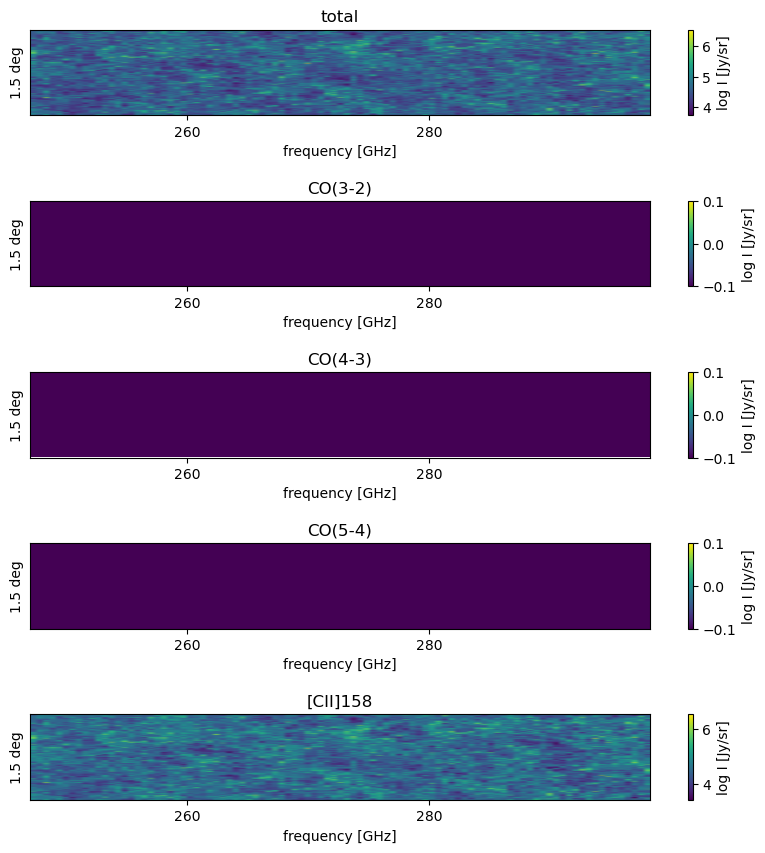

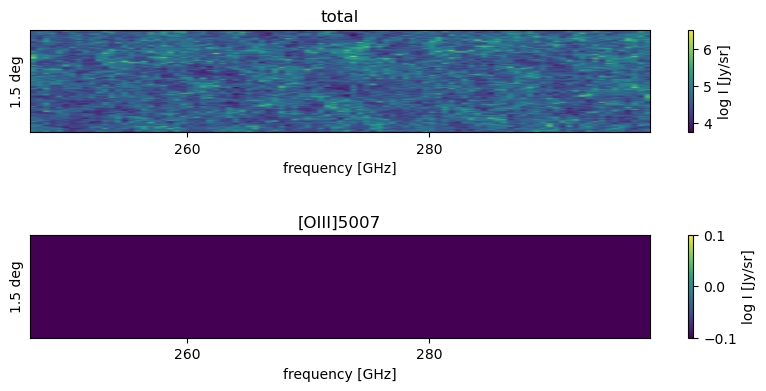

In [8]:
data_dir = "../output_TNG300-1"

path = "../output_TNG300-1/map_5400.0sec_fmin248.0_fmax301.0_angular27.0_spectral500.0_sigma0.2_alpha15.0_th-1.0.h5"

freq, intensity, intensity_line, attrs = load_data(path)
show_map(freq, intensity, intensity_line, side_length=attrs["side_length"], lines_to_show=["CO(3-2)", "CO(4-3)", "CO(5-4)", "[CII]158"], dy=-1, use_log=True)

freq, intensity, intensity_line, attrs = load_data(path)
show_map(freq, intensity, intensity_line, side_length=attrs["side_length"], lines_to_show=["[OIII]5007"], dy=-1, use_log=True)

### Voxel intensity distribution

freqency shape:  (96,)
intensity shape:  (200, 200, 95)


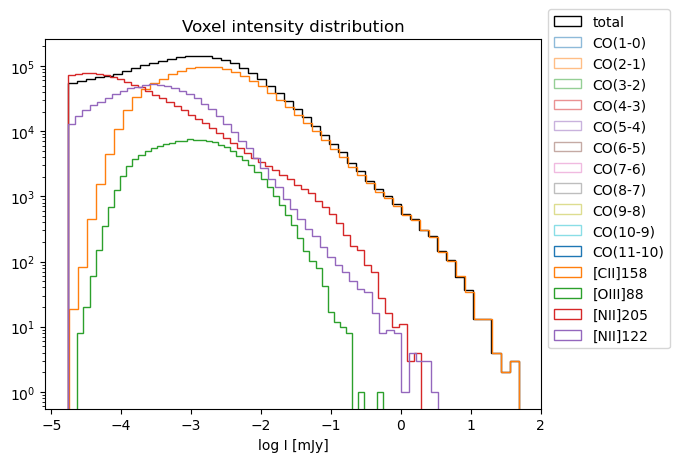

In [9]:

path = "../output_TNG300-1/map_5400.0sec_fmin248.0_fmax301.0_angular27.0_spectral500.0_sigma0.2_alpha15.0_th-1.0.h5"
freq, intensity, intensity_line, attrs = load_data(path)

dtheta = attrs["angular_resolution"] # [arcsec]

factor = (dtheta*arcsec)**2 * 1e3 # [Jy/sr] -> [mJy]
int_min = 1 * factor

plt.title("Voxel intensity distribution")

intensity *= factor
intensity = intensity[intensity > int_min]
intensity = intensity.reshape(-1)
plt.hist(np.log10(intensity), bins=50, color="k", label="total", histtype="step")
count = 0
for i, line_name in enumerate(line_names):
    if line_name in ["CO(1-0)", "CO(2-1)", "CO(3-2)", "CO(4-3)", "CO(5-4)", "CO(6-5)", "CO(7-6)", "CO(8-7)", "CO(9-8)", "CO(10-9)", "CO(11-10)", "[CII]158", "[OIII]88", "[NII]205", "[NII]122"]:
        temp = intensity_line[line_name]
        temp *= factor
        temp = temp[temp > int_min]
        temp = temp.reshape(-1)

        alpha = 0.5 if count < 10 else 1
        plt.hist(np.log10(temp), bins=50, alpha=alpha, label=line_name, histtype="step")
        count += 1

plt.xlabel("log I [mJy]")
plt.yscale("log")
plt.legend(bbox_to_anchor=(1,1.1))

### Visualize spectrum 

freqency shape:  (96,)
intensity shape:  (200, 200, 95)


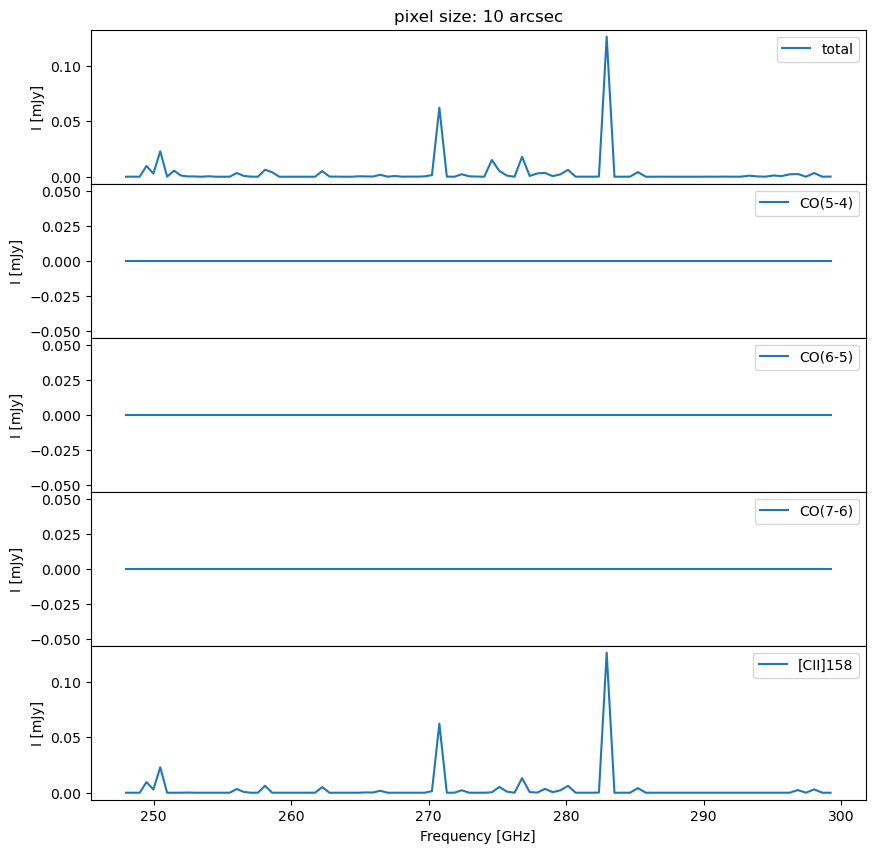

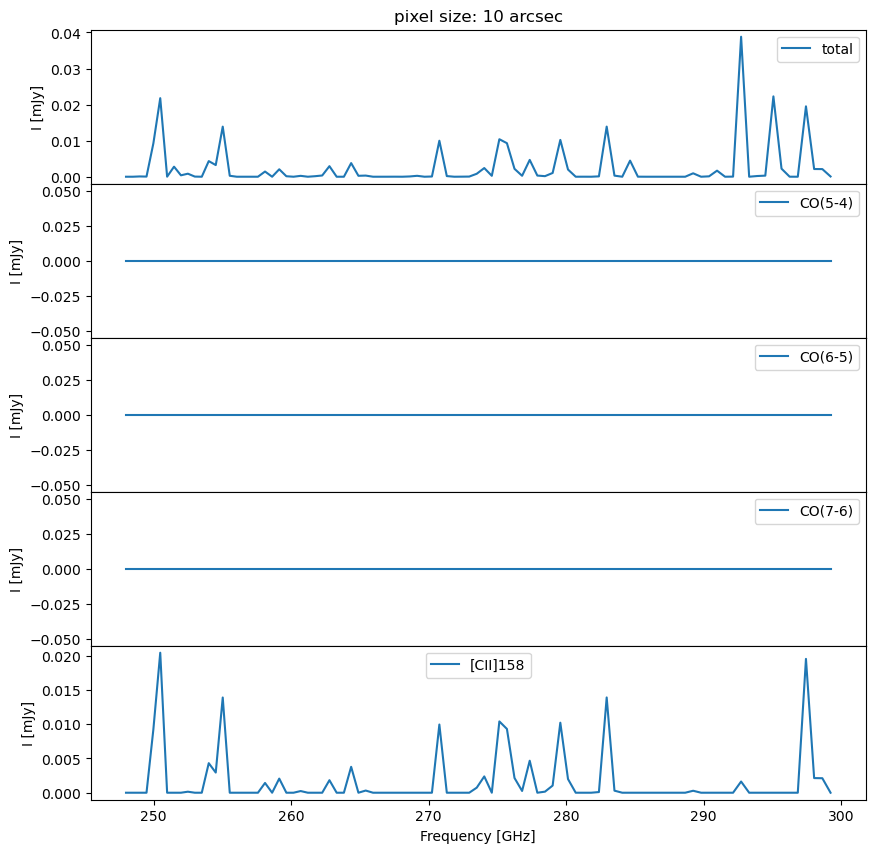

In [10]:

path = "../output_TNG300-1/map_5400.0sec_fmin248.0_fmax301.0_angular27.0_spectral500.0_sigma0.2_alpha15.0_th-1.0.h5"
freq, intensity, intensity_line, attrs = load_data(path)

dtheta = attrs["angular_resolution"] # [arcsec]

factor = (dtheta*arcsec)**2 * 1e3 # [Jy/sr] -> [mJy]

lines_to_show = ["CO(5-4)", "CO(6-5)", "CO(7-6)", "[CII]158"]
Nmap = len(lines_to_show) + 1

for i in range(2):
    plt.figure(figsize=(10, Nmap*2))
    plt.subplots_adjust(hspace=0)
    plt.subplot2grid((Nmap,1),(0,0))
    plt.title("pixel size: 10 arcsec")
    plt.ylabel("I [mJy]")

    plt.plot(freq[:-1], intensity[i,0,:] * factor, label="total")
    plt.legend()
    count = 1
    for j, line_name in enumerate(line_names):
        if line_name in lines_to_show:
            plt.subplot2grid((Nmap,1),(count,0))
            plt.ylabel("I [mJy]")
            plt.plot(freq[:-1], intensity_line[line_name][i,0,:] * factor, label=line_name)
            count += 1

            plt.legend()

    plt.xlabel("Frequency [GHz]")
            

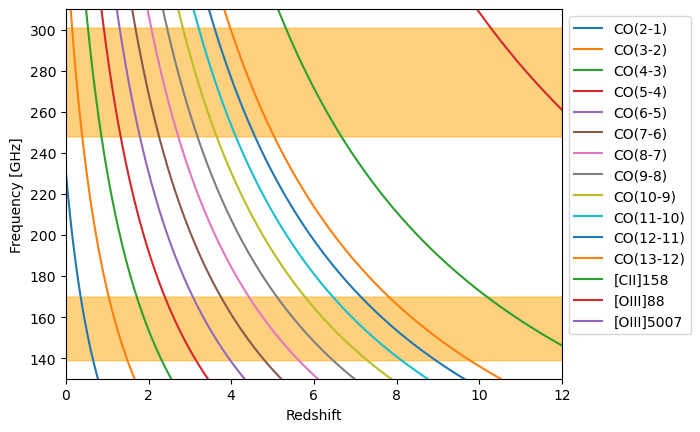

In [11]:
plt.figure()

x = np.linspace(0, 12, 1000)

plt.fill_between(x, 139, 170, color="orange", alpha=0.5)
plt.fill_between(x, 248, 301, color="orange", alpha=0.5)

for key, value in line_dict.items():
    if key == "CO(1-0)":
        continue
    if "[CI]" in key:
        continue
    if "[NII]" in key:
        continue

    f_obs = value[0] / GHz / (1 + x)
    plt.plot(x, f_obs, label=key)

plt.xlabel("Redshift")
plt.ylabel("Frequency [GHz]")
plt.xlim([0, 12])
plt.ylim([130, 310])
plt.legend(bbox_to_anchor=(1,1.))

    

Text(0, 0.5, '$\\rm SFRD \\ [M_\\odot \\ / \\ yr\\ / \\ Mpc^3]$')

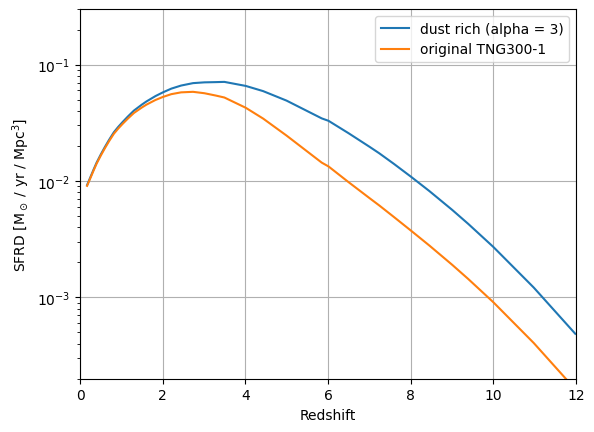

In [39]:
def factor(z, alpha=3, z_middle=5):
    return (alpha - 1) * (0.5 * ( np.tanh( 0.5 * (z - z_middle) ) + 1 )) + 1

plt.figure()

data = np.loadtxt("./sfrd.txt")
z = data[:,0]
sfrd = data[:,1]

#plt.plot(z, sfrd * factor(z, alpha=10), label="more dust rich (alpha = 10)")
plt.plot(z, sfrd * factor(z), label="dust rich (alpha = 3)")
plt.plot(z, sfrd, label="original TNG300-1")
#plt.scatter(z, sfrd * factor(z, alpha=10), label="more dust rich (alpha = 10)")


plt.plot
plt.yscale("log")
plt.xlim([0, 12])
plt.ylim([2e-4, 0.3])
plt.grid()
plt.legend()
plt.xlabel("Redshift")
plt.ylabel(r"$\rm SFRD \ [M_\odot \ / \ yr\ / \ Mpc^3]$")


freqency shape:  (96,)
intensity shape:  (200, 200, 95)


Text(0.5, 0, '$f \\rm \\ [arcsec^{-1}]$')

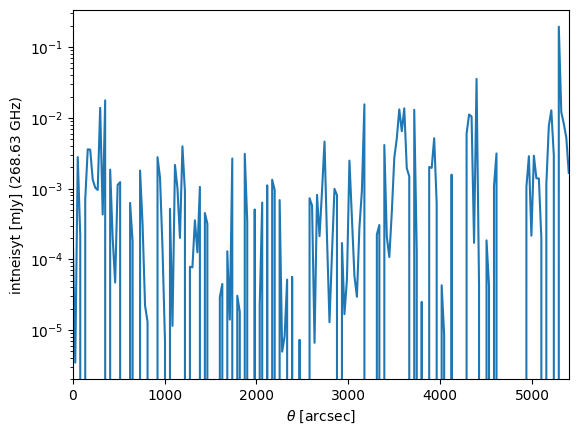

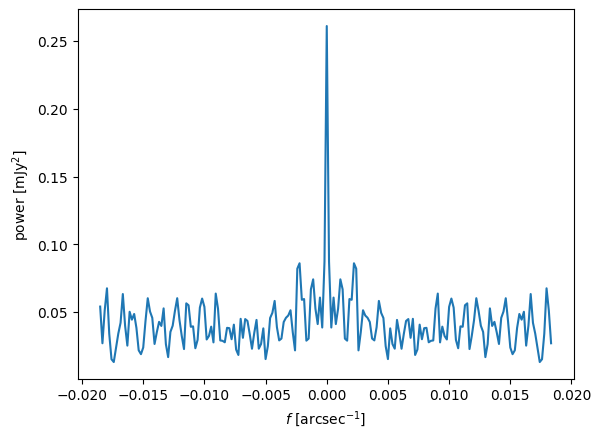

In [41]:
## test scan speed

path = "./output_TNG300-1/map_5400.0sec_fmin248.0_fmax301.0_angular27.0_spectral500.0_sigma0.2_alpha15.0_th-1.0.h5"
freq, intensity, intensity_line, attrs = load_data(path)
dtheta = attrs["angular_resolution"] # [arcsec]

index = 15
intensity_scan = intensity[:,index,40] * (dtheta*arcsec)**2 * 1e3 #[mJy]
x = np.linspace(0, len(intensity_scan), len(intensity_scan)) * dtheta 

plt.plot(x, intensity_scan)
plt.xlim([0, 200*dtheta])
plt.yscale("log")
plt.xlabel(r"$\theta \ \rm [arcsec]$")
plt.ylabel(f"intneisyt [mJy] ({freq[40]:.2f} GHz)")

plt.figure()

power = np.fft.fftshift(np.abs(np.fft.fft(intensity_scan))**2)
k = np.fft.fftshift(np.fft.fftfreq(len(intensity_scan), d=dtheta))
plt.plot(k, power)
plt.ylabel(r"$\rm power\ [mJy^2]$")
plt.xlabel(r"$f \rm \ [arcsec^{-1}]$")


freqency shape:  (96,)
intensity shape:  (200, 200, 95)


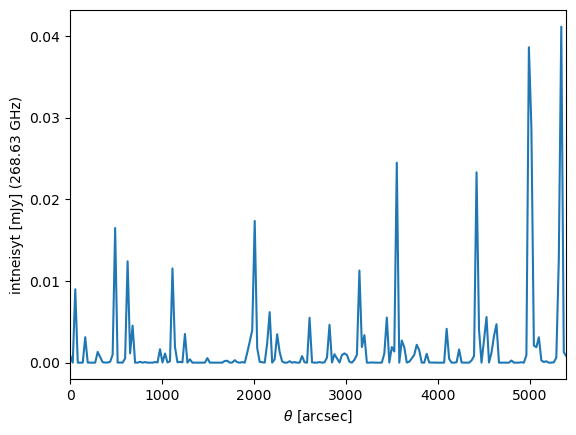

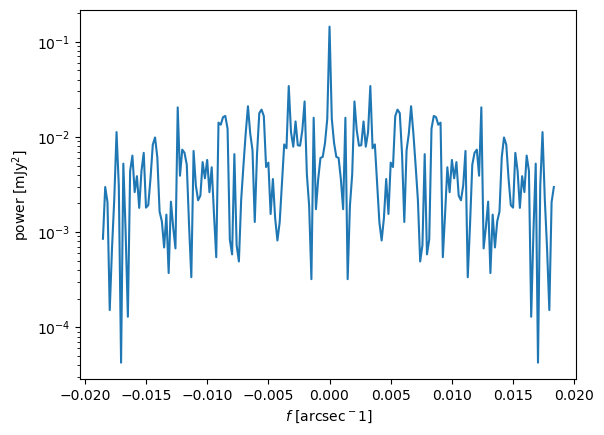

In [12]:
## test scan speed
path = "../output_TNG300-1/map_5400.0sec_fmin248.0_fmax301.0_angular27.0_spectral500.0_sigma0.2_alpha15.0_th-1.0.h5"
freq, intensity, intensity_line, attrs = load_data(path)
detheta = attrs["angular_resolution"] # [arcsec]

intensity_scan = intensity[:,10,40] * (dtheta*arcsec)**2 * 1e3 #[mJy]
x = np.linspace(0, len(intensity_scan), len(intensity_scan)) * dtheta 

plt.plot(x, intensity_scan)
plt.xlim([0, 200*dtheta])
#plt.yscale("log")
plt.xlabel(r"$\theta \ \rm [arcsec]$")
plt.ylabel(f"intneisyt [mJy] ({freq[40]:.2f} GHz)")

plt.figure()

power = np.fft.fftshift(np.abs(np.fft.fft(intensity_scan))**2)
k = np.fft.fftshift(np.fft.fftfreq(len(intensity_scan), d=dtheta))
plt.plot(k, power)
plt.ylabel(r"$\rm power\ [mJy^2]$")
plt.xlabel(r"$f \rm \ [arcsec^-1]$")
plt.yscale("log")
